# 자연어처리 및 응용 중간고사 (2024-1학기)
- 코드 및 주석
- 큰 분류는 Markdown으로 설명
  - 데이터셋 등
- 각 파트 마지막별로 간단한 소감문

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 날씨 데이터를 LSTM으로 처리하는 프로그램을 작성해보자.
   사용하는 데이터 세트는 Max Planck Institute for Biogeochemistry에서 기록한 Jena Climate 데이터 세트는 온도, 압력, 습도 등 14가지 특징으로 구성되며 10분에 한 번씩 기록된다.
   https://keras.io/examples/timeseries/를 참조한다.

## 목표
- 위 날씨 데이터를 이용하여 5일간의 데이터를 가지고, 12시간 이후를 예측하는 프로그램을 작성할 것이다.

[ref1] [링크](https://deep-deep-deep.tistory.com/60)

## Dataset Download

https://www.kaggle.com/datasets/mnassrib/jena-climat 에서 다운로드 진행


In [27]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import LSTM, Dense

## Data load

In [28]:
csv_path = "/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


## Dataset detail
| Index | Feature   | Format                | Description |
|-------|-----------|-----------------------|-------------|
| 1     | Date Time | 01.01.2009 00:10:00   | 날짜 및 시간 참조 |
| 2     | p (mbar)  | 996.52                | 내부 압력을 정량화하기 위해 사용되는 파스칼 SI 파생 단위입니다. 기상 보고서에서는 일반적으로 대기압을 밀리바(bar)로 표시합니다. |
| 3     | T (degC)  | -8.02                 | 섭씨 온도 |
| 4     | Tpot (K)  | 265.4                 | 켈빈 온도 |
| 5     | Tdew (degC)| -8.9                 | 습도에 따른 섭씨 온도입니다. 이슬점은 공기 중에 있는 물의 절대량을 측정하는 척도로, 공기가 그 안의 모든 수분을 유지할 수 없게 되면 물이 응결되는 온도입니다. |
| 6     | rh (%)    | 93.3                  | 상대 습도는 공기가 수분 증기로 얼마나 포화되었는지를 나타내는 척도입니다. %RH는 수집 객체 내에 포함된 물의 양을 결정합니다. |
| 7     | VPmax (mbar)| 3.33                | 포화 증기압 |
| 8     | VPact (mbar)| 3.11                | 증기압 |
| 9     | VPdef (mbar)| 0.22                | 증기압 부족 |
| 10    | sh (g/kg) | 1.94                  | 특정 습도 |
| 11    | H2OC (mmol/mol) | 3.12            | 수증기 농도 |
| 12    | rho (g/m ** 3) | 1307.75          | 공기 밀도 |
| 13    | wv (m/s)  | 1.03                  | 풍속 |
| 14    | max. wv (m/s)| 1.75               | 최대 풍속 |
| 15    | wd (deg)  | 152.3                 | 풍향 (도) |

## 기본값 확인
```
데이터셋에서 기본적으로, 전처리가 되어있다.
Missing Attribute Values: none
```

In [29]:
# data 기본값 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [30]:
# data 상위 5개 정보 확인
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [31]:
# data 하위 5개 정보 확인
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


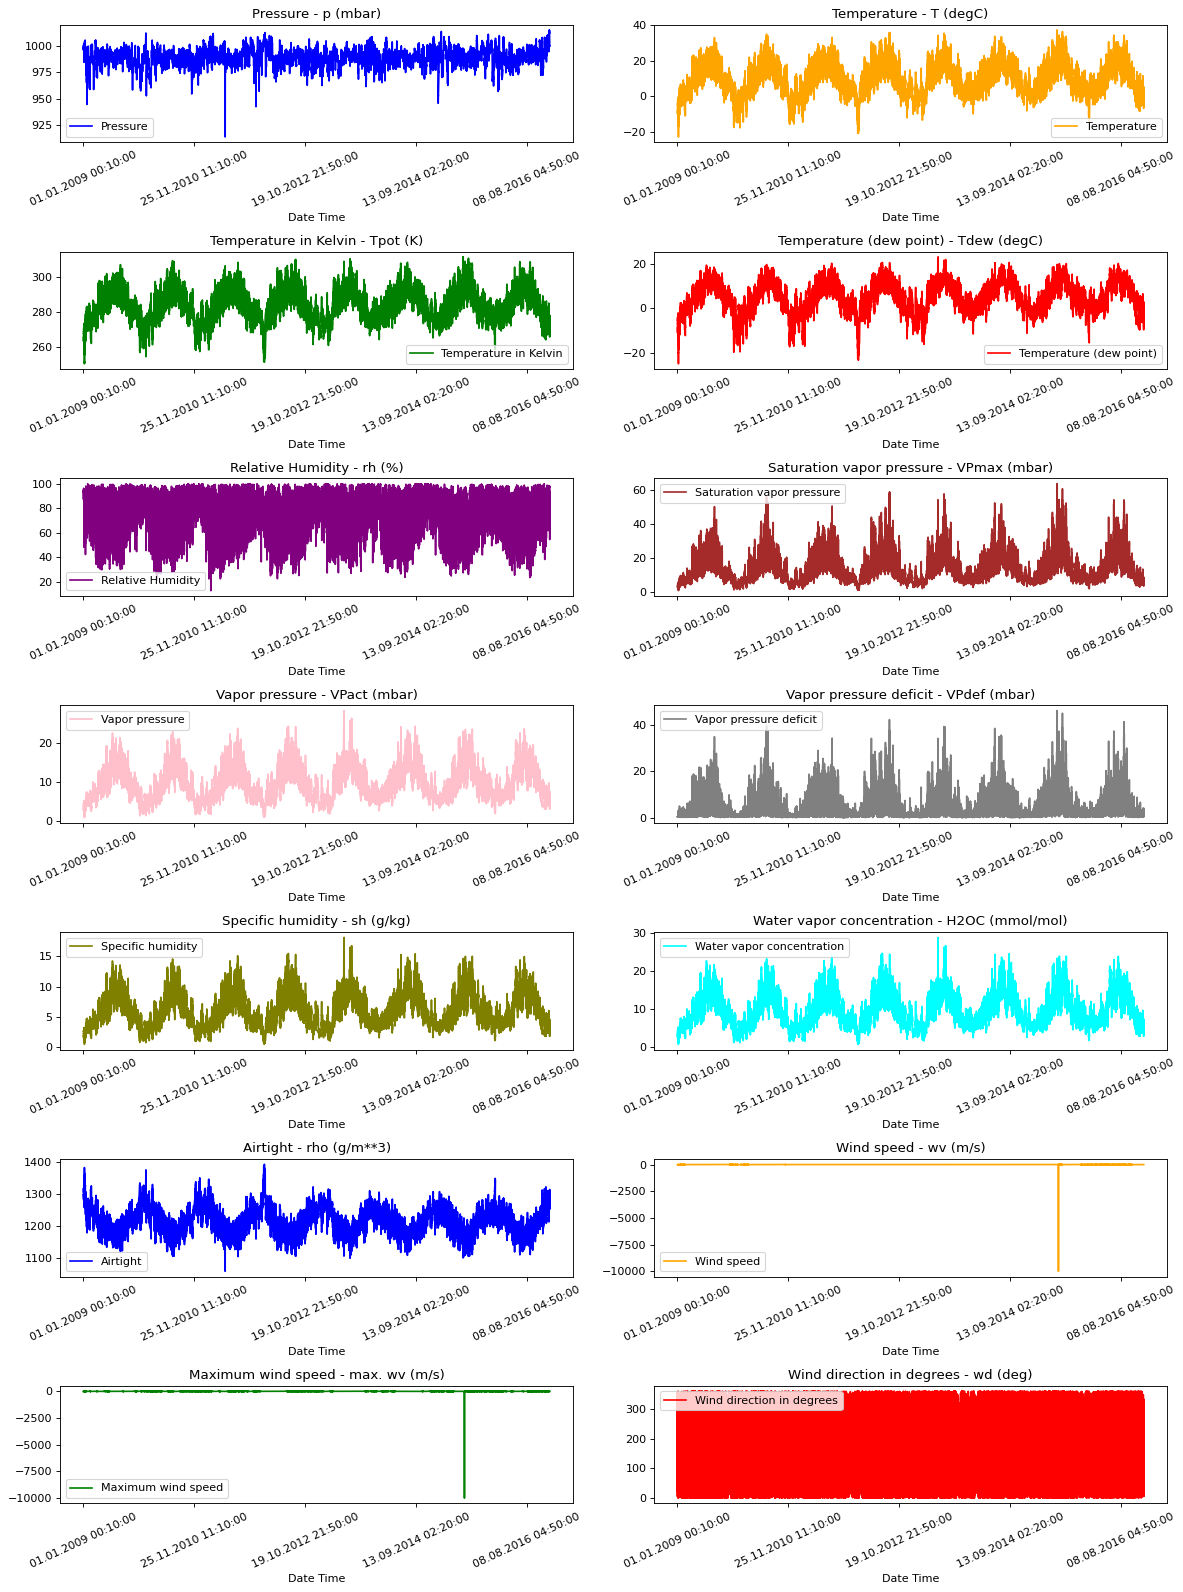

In [32]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

위 그래프를 해석하면,
- p (mbar)는 전체적으로 980 ~ 1010사이에 위치하며,2011년 상반기에 920의 낮은 기록을 가지고 있다.
- T (degC)와 Tpot (K)은 각각 섭씨와 화씨로, 수치만 다를 뿐 형태는 동일하다. 섭씨 35 ~ -15정도로 1년 기온차가 큰 편으로 파악된다.
- Tdew (degC)는 습도에 따른 공기 중 물의 절대량을 측정하는 지표로 섭씨-화씨 온도를 따라가는 형태를 보인다.
- rh (%)는 상대습도로, 연초/말에 높아지고, 연중에는 40%로 낮아진다. 여름 온도가 35 ~ 40 섭씨이기에, 수분량이 적어지는 것으로 파악된다.
- VPmax (mbar)와 VPact (mbar), VPdf (mbar), H2OC (mmol/mol)는 전체적 형태는, 연초/말에 낮아지고 연중에 높아지는 형상을 보인다. 공기중 수분과 관련된 내용이라 그래프의 형상이 따라가는 것으로 보인다.
- rho (g/m ** 3)은 수증기 농도로, 위 위의 4개의 그래프와 반대되는 모습을 보인다. 연초/말에 높고, 연중에 습도가 낮다. 전체적인 모습은 상대습도와 비슷하며, 그래프 형태도 비슷하다. 이유도 비슷하게 온도가 높아, 수분량이 적어져 이와 같은 형태를 보이는 것이다.
- wv (m/s)와 max.wv (m/s)는 0을 나타내다, 2015년 하반기에 한 번 값이 튄다.

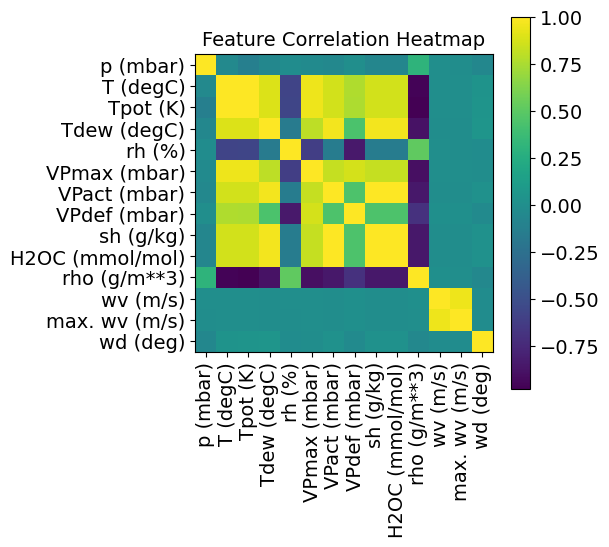

In [14]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

각 Feature간 상관관계 분석을 위해 Heatmap을 작성하였다.
- 1(노란색)에 가까울수록 상관점수가 높다. 0(보라색)에 가까울수록 상관점수가 낮다.
- 대각선의 상관관계점수가 1로 나온 것은, 자기 자신을 상관관계 분석한 것이기에 노란색으로 나온다.
- 전체적인 그래프의 형태가 비슷한 것들은 상관관계 점수가 매우 높게 나옴을 알 수 있다.

## Pre-processing

### 결측치 제거

In [33]:
# 결측치 확인
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [34]:
# 결측치 제거 / 결측치가 없어서 제거가 안 된 것이 정상
df = df.dropna()
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

## 훈련 데이터 구성

In [35]:
# 데이터셋 분할을 위한 비율 설정, 논문과 동일하게 0.715로 진행
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))

step = 6 # 샘플링할 간격
past = 720 # input sequance 길이
future = 72 # prediction할 future 길이

learning_rate = 0.001 # lr 설정
batch_size = 256 # 배치 사이즈 설정
epochs = 7 # 에포크 설정, 논문과 동일한 에포크는 물리적 환경으로 불가능하여 7로 설정

In [36]:
# 훈련 데이터의 평균과 표준 편차를 이용해서 데이터를 정규화 진행
def normalize(data, train_split):
 data_mean = data[:train_split].mean(axis=0)
 data_std = data[:train_split].std(axis=0)
 return (data - data_mean) / data_std

In [37]:
# feature selection 진행 후 훈련 진행할 것.
# index는 date로 설정
print(
 "The selected parameters are:",
 ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


## 훈련평가 진행

In [39]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [40]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## 예측 진행

In [43]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# 배치 한 개를 가져와 shape를 확인
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


## 학습 진행
- summary로 모델의 input layer와 lstm 그리고 dense를 확인

In [45]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs) # layer를 32로 조정하여 진행. 하드웨어적 문제로 인한 것.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                5120      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 모델이 최적의 결과값을 도출하면, 해당 모델의 가중치를 저장

In [46]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
 monitor="val_loss",
 filepath=path_checkpoint,
 verbose=1,
 save_weights_only=True,
 save_best_only=True,
)

- 모델 train / validation으로 loss()와 accuracy를 확인

In [47]:
history = model.fit(
 dataset_train,
 epochs=epochs,
 validation_data=dataset_val,
 callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/7
1171/1172 [============================>.] - ETA: 0s - loss: 0.1823
Epoch 1: val_loss improved from inf to 0.14466, saving model to model_checkpoint.h5
1172/1172 [==============================] - 75s 61ms/step - loss: 0.1822 - val_loss: 0.1447
Epoch 2/7
1171/1172 [============================>.] - ETA: 0s - loss: 0.1243
Epoch 2: val_loss improved from 0.14466 to 0.13489, saving model to model_checkpoint.h5
1172/1172 [==============================] - 67s 57ms/step - loss: 0.1243 - val_loss: 0.1349
Epoch 3/7
1170/1172 [============================>.] - ETA: 0s - loss: 0.1153
Epoch 3: val_loss did not improve from 0.13489
1172/1172 [==============================] - 66s 56ms/step - loss: 0.1153 - val_loss: 0.1383
Epoch 4/7
1172/1172 [==============================] - ETA: 0s - loss: 0.1107
Epoch 4: val_loss did not improve from 0.13489
1172/1172 [==============================] - 63s 54ms/step - loss: 0.1107 - val_loss: 0.1386
Epoch 5/7
1171/1172 [============================>

- train / validation loss() 를 시각화

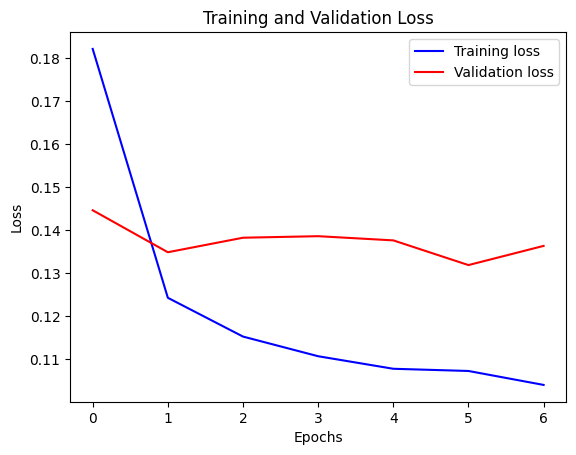

In [48]:
def visualize_loss(history, title):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, "b", label="Training loss")
  plt.plot(epochs, val_loss, "r", label="Validation loss")
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

visualize_loss(history, "Training and Validation Loss")

## Prediction

8/8 [==============================] - 0s 4ms/step


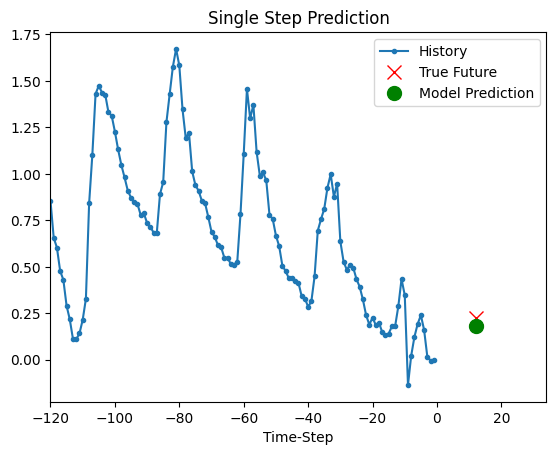

8/8 [==============================] - 0s 4ms/step


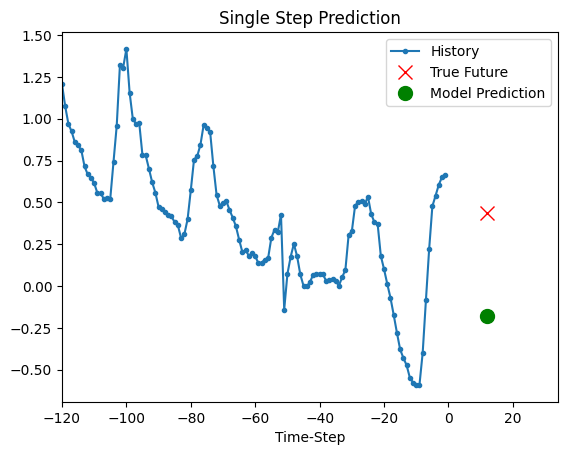

8/8 [==============================] - 0s 4ms/step


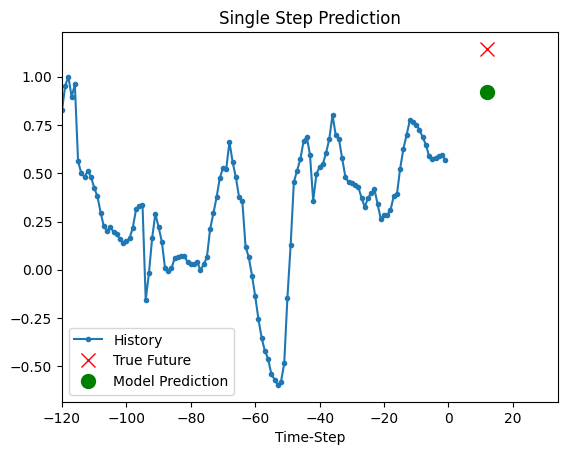

In [50]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

- validation set에서 3개의 데이터를 가지고 예측을 진행하였다. 시간(x)에 따른 온도(y)에서, 12시간 이후를 예측하였다.
- 예측결과 : 1번의 경우 거의 정확하게 예측되었으며, 2/3번의 경우, 오차값이 생각보다 크게 작동하였다. 그 중에서 2번째 보다 3번째가 예측에 성공하였다고 볼 수 있다.
- 개선점 : 모델의 복잡성을 높히면 정확도가 올라갈 것이다. 5일간의 데이터 말고 1, 2일간의 데이터로도 예측을 하면 다른 결과가 나올 것이다. 이러한 방법으로 모델의 예측 정확도를 높힐 수 있으리라 생각한다.

# 2. 로이터 뉴스를 분류할 수 있는 프로그램을 작성해보자.
   케라스에서는 로이터 뉴스 데이터를 제공한다. 로이터 뉴스 데이터는 11,258개의 뉴스 기사를 46개의 뉴스 카테고리로 분류
   하여 제공한다.
   **46개의 뉴스 카테고리에서 10개의 뉴스 카테고리를 선택하여 카테고리별 하나의 뉴스를 출력하여라.**

## Dataset 설명
- 1986년 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 데이터.
- 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋으로 46개의 토픽이 있고 어떤 토픽은 다른 것에 비해 데이터가 많다.
- 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있다.
- 이 데이터셋은 원본 로이터 데이터셋(135개 토픽) 중 샘플이 많은 것을 뽑아 간단하게 만든 것이다.
- defalt값으로 8,982개의 훈련 샘플과 2,246개의 테스트 샘플이 있음.
- IMDB, MNIST와 마친가지로 케라스에 포함되어 있다.
- IMDB과 마찬가지로 미리 전체 데이터셋의 단어를 고유한 정수 인덱스로 바꾼 후 훈련/테스트 데이터로 나누어 놓았다

[ref2] [링크](https://github.com/gggggeun/DS_study/blob/main/5.%20%EB%94%A5%EB%9F%AC%EB%8B%9D(deep%20learning)/practice/3.%20Reuters_dataset(%EB%89%B4%EC%8A%A4%EA%B8%B0%EC%82%AC_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98).ipynb)

[ref3] [링크](https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-17%EC%9D%BC%EC%B0%A8-%EB%A1%9C%EC%9D%B4%ED%84%B0-%EB%89%B4%EC%8A%A4-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0-f5466abe9196)

[ref] [링크](https://velog.io/@ranyjoon/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%98%88%EC%A0%9C%EC%82%B4%ED%8E%B4%EB%B3%B4%EA%B8%B0-xgf28g1v)

## 목표
학습된 모델이, 랜덤한 숫자를 뽑고 해당 기사를 출력하여 기사를 보여주는 프로그램 제작

## Dataset import

In [1]:
from tensorflow import keras
from keras.datasets import reuters

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

## 훈련 진행

In [7]:
# 사용할 단어를 10,000개로 제한하고, train/test split을 진행
num_words = 10000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words)

In [8]:
# 로이터 뉴스 데이터셋에서 각 단어와 고유 인덱스를 매핑하는 사전을 불러옴
word_index = reuters.get_word_index()

# 단어 인덱스를 단어로 매핑하는 사전을 생성 (인덱스와 단어의 위치를 바꿈)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 첫 번째 훈련 데이터(x_train[0])를 사람이 읽을 수 있는 텍스트로 디코딩
# 각 인덱스에 대해 3을 빼서 원래의 단어 인덱스를 얻음 (데이터셋의 특성상 처음 세 인덱스는 특별한 용도로 예약되어 있음)
# reverse_word_index를 사용해 각 인덱스에 해당하는 단어를 찾고, 찾을 수 없는 경우 '?'로 대체
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in x_train[0]])

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    # 결과를 저장할 2D 넘파이 배열 초기화: 모든 요소가 0이고, 크기는 (시퀀스의 길이, 차원 수)
    results = np.zeros((len(sequences), dimension))

    # 각 시퀀스에 대해 반복
    for i, sequence in enumerate(sequences):
        # 시퀀스 내의 각 인덱스(j)에 대해
        for j in sequence:
            # 해당 시퀀스의 i번째, 인덱스의 j번째 위치를 1로 설정
            results[i, j] = 1.

    # 완성된 벡터화된 시퀀스 배열 반환
    return results

In [10]:
# 훈련/테스트 데이터를 벡터화하는 함수 호출, 데이터들을 원-핫 인코딩된 형태로 변환
train_data = vectorize_sequences(x_train)
test_data = vectorize_sequences(x_test)

In [11]:
# 훈련/테스트 레이블을 범주형으로 변환
train_labels = to_categorical(y_train, 46)
test_labels = to_categorical(y_test, 46)

## CNN 모델 구성

In [18]:
model = models.Sequential()
model.add(layers.Dense(128, activation = 'relu', input_shape = (10000,))) # Input은 처음 입력층만
model.add(layers.Dense(64, activation = 'relu')) # 활성함수로 relu 사용
model.add(layers.Dense(46, activation = 'softmax')) # 출력층은 softmax 사용

In [19]:
# Best 모델 저장 및 모델 조기 종료를 위한 콜백함수 사용
ES = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 7) # 7에포크동안 개선되지 않을 시 모델 종료
MC = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1,
save_best_only = True)

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# train / validation 분류
x_val = train_data[:1000]
partial_x_train = train_data[1000:]
y_val = train_labels[:1000]
partial_y_train = train_labels[1000:]

In [23]:
history = model.fit(partial_x_train,partial_y_train,
                    epochs=20, batch_size=512, # 20에포크, 배치는 512로 진행
                    callbacks=[ES, MC],
                    validation_data =(x_val,y_val))

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9567

16/16 [==============================] - 3s 203ms/step - loss: 0.1243 - accuracy: 0.9567 - val_loss: 1.0633 - val_accuracy: 0.7890
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9588

16/16 [==============================] - 3s 171ms/step - loss: 0.1153 - accuracy: 0.9588 - val_loss: 1.0011 - val_accuracy: 0.7980
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9587

16/16 [==============================] - 4s 278ms/step - loss: 0.1144 - accuracy: 0.9587 - val_loss: 1.1217 - val_accuracy: 0.7840
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9567

16/16 [==============================] - 3s 212ms/step - loss: 0.1195 - accuracy: 0.9567 - val_loss: 0.9967 - val_accuracy: 0.8020
Epoch 5/20
16/16 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9578

16/16 [==============================] - 2s 154ms/step - loss: 0.1155 - accuracy: 0.9578 - val_loss: 1.1364 - val_accuracy: 0.7870
Epoch 6/20
16/16 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9577

16/16 [==============================] - 2s 129ms/step - loss: 0.1140 - accuracy: 0.9577 - val_loss: 1.0161 - val_accuracy: 0.8070
Epoch 7/20
16/16 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9568

16/16 [==============================] - 2s 119ms/step - loss: 0.1099 - accuracy: 0.9568 - val_loss: 1.0440 - val_accuracy: 0.7960
Epoch 8/20
16/16 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9587

16/16 [==============================] - 2s 125ms/step - loss: 0.1070 - accuracy: 0.9587 - val_loss: 1.0267 - val_accuracy: 0.7990
Epoch 9/20
16/16 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9582

16/16 [==============================] - 3s 171ms/step - loss: 0.1090 - accuracy: 0.9582 - val_loss: 1.0839 - val_accuracy: 0.7990
Epoch 10/20
16/16 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9595

16/16 [==============================] - 2s 123ms/step - loss: 0.1050 - accuracy: 0.9595 - val_loss: 1.0318 - val_accuracy: 0.7970
Epoch 11/20
16/16 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9580

16/16 [==============================] - 2s 116ms/step - loss: 0.1075 - accuracy: 0.9580 - val_loss: 1.1207 - val_accuracy: 0.7900
Epoch 11: early stopping


- 7에포크동안 모델개선이 이뤄지지 않으면 모델이 중단되게 하였다. 이는 11에포크에서 중단되었다.

In [24]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print("Test accuracy:", test_acc)

71/71 [==============================] - 0s 6ms/step - loss: 1.2129 - accuracy: 0.7783
Test accuracy: 0.7782725095748901


- 정확도는 77.8%로, 모델이 아주 약간 유의미함을 알 수 있다. (마의 75%를 넘었다...)

In [26]:
# 로이터 뉴스 데이터셋의 단어 인덱스 맵을 불러온다
word_index = reuters.get_word_index()

# 단어 인덱스의 각 값에 3을 더한다.
word_index = {k: (v + 3) for k, v in word_index.items()}

# 특별 토큰을 단어 인덱스 맵에 추가한다
word_index["<PAD>"] = 0      # 패딩용 토큰
word_index["<START>"] = 1    # 문장 시작 토큰
word_index["<UNK>"] = 2      # 알 수 없는 단어(사전에 없는 단어) 표시용 토큰
word_index["<UNUSED>"] = 3   # 사용되지 않는 토큰

# 인덱스를 단어로 매핑가능하게 한다
index_word = {v: k for k, v in word_index.items()}

In [29]:
# 랜덤한 수를 뽑아낸다
def decode_review(text):
 return ' '.join([index_word.get(i, '') for i in text if i > 3])

np.random.seed(42)
random.seed(42)

# 카테고리 46개중 10개를 랜덤하게 뽑는다
selected_categories = np.random.choice(range(46), 10, replace=False)

In [30]:
news_from_categories = {}

# 선택된 카테고리들에 대해 반복
for category in selected_categories:
    news_indices = [i for i, label in enumerate(y_train) if label == category] # 해당 카테고리에 속하는 뉴스 기사의 인덱스를 모아 리스트를 생성
    random_news_index = random.choice(news_indices) # 생성된 리스트에서 무작위로 하나의 인덱스를 선택
    news_from_categories[category] = decode_review(x_train[random_news_index]) # 선택된 인덱스에 해당하는 뉴스 기사를 디코딩하고 딕셔너리에 저장

In [34]:
print("====Output for 10 categorier====")
for category, news_text in news_from_categories.items():
 print(f"{category}번 : {news_text[:77]}...")

====Output for 10 categorier====
39번 : hoechst ag's lt f u s unit hoechst celanese corp said it has begun projects t...
25번 : the gold mining industry had another exceptional year in 1986 with tonnage mi...
26번 : european free market tin traders made a somewhat response to plans for a kual...
44번 : chicago mercantile exchange floor traders and commission house representative...
35번 : canada's leading composite indicator advanced 0 4 pct in december after gaini...
41번 : mobil oil singapore pte will raise pump prices of petrol from june 2 a spokes...
4번 : cyacq corp said it extended its 80 dlr a share tender offer for cyclops corp ...
12번 : norway's central bank reserves totalled 91 06 billion crowns in january again...
8번 : canadian narrowly defined money supply m 1 fell 430 mln dlrs to 35 65 billion...
3번 : shr 66 cts vs 33 cts net 2 955 000 vs 1 563 000 revs 26 1 mln vs 23 9 mln 12 ...


- 텍스트 분류 모델을 직접 만들고, 카테고리를 예측하는 프로그램을 제작하였다. 정확도는 78%정도로 높다고 할 수 없는 수치지만, 못 쓸 정도는 아니였다.

# 3. MNIST의 fashion 데이터 세트에 대하여 14.3 기본형 오토인코더와 14.4 노이즈 제거 오토인코더 프로그램을 작성해보자.

[ref5] 수업 ppt (제14장. 생성 모델)

## Dataset 설명
- 패션-MNIST 데이터 세트는 잘란도의 기사 이미지 데이터베이스로, 60,000개의 예제로 구성된 훈련 세트와 10,000개의 예제로 구성된 테스트 세트로 구성되어 있습니다.
- 각 예제는 28x28 흑백 이미지로, 10개 클래스의 레이블과 연관되어 있습니다.
- Fashion-MNIST는 머신 러닝 알고리즘 벤치마킹을 위해 원래의 MNIST 데이터 세트를 직접 대체할 수 있도록 고안되었습니다.

## 주요기능
- 패션-MNIST에는 잘란도의 기사 이미지 중 60,000개의 트레이닝 이미지, 10,000개의 테스트 이미지로 구성
- 데이터 세트는 28x28 픽셀 크기의 그레이 스케일 이미지로 구성
- 각 픽셀에는 해당 픽셀의 밝기 또는 어두움을 나타내는 픽셀 값이 하나씩 연결되어 있으며, 숫자가 클수록 더 어둡다는 의미.
- 이 픽셀 값은 0에서 255 사이의 정수임

## Dataset load

In [74]:
from keras.datasets.fashion_mnist import load_data

In [75]:
# 패션 MNIST 데이터셋을 로드하여 train/test split.
(x_train, _), (x_test, _) = load_data()
print(x_train.shape, x_test.shape)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

(60000, 28, 28) (10000, 28, 28)


## Data generalization

In [76]:
# data를 0에서 1 사이의 값으로 정규화.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [77]:
# image를 1d-vector로 변환(flatten)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [78]:
# input / encoding 차원을 설정
input_dim = 784 # 28x28
encoding_dim = 32

## Model = Autoencoder

In [79]:
# input layer과 encoded layer 선언
input_img = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_img) # 활성함수를 relu로 기울기 소실 해결
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded) # sigmoid 활성함수로 사용

In [80]:
# autoencoder 선언
autoencoder = keras.Model(input_img, decoded)
# Model complie
autoencoder.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError()) # 옵티마이저로 adam 사용
autoencoder.fit(x_train, x_train,
  epochs=50, # epoch 50번
  batch_size=256, # batch는 256개
  shuffle=True, # 데이터셋 섞기
  validation_data=(x_test, x_test)) # validation 진행

Epoch 1/50
235/235 [==============================] - 3s 8ms/step - loss: 0.0605 - val_loss: 0.0328
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0250
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0195 - val_loss: 0.0183
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0138 - val_loss: 0.013

In [81]:
# 모델 출력 결과를 확인
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 1ms/step


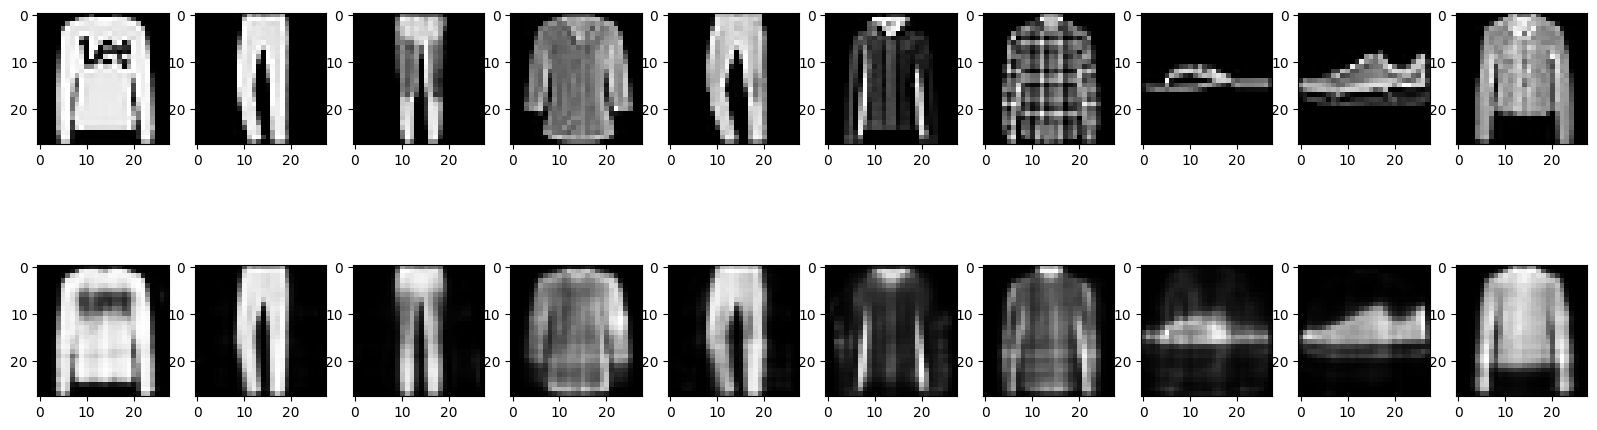

In [82]:
n = 10
plt.figure(figsize=(20, 6))  # 그래프의 전체적인 크기 설정

# 그레이스케일로 출력된 결과 확인
for i in range(1, n + 1):
  ax = plt.subplot(2, n, i)  # 행이 2개, 열이 n개인 그래프의 i번째 위치에 서브플롯 설정
  plt.imshow(x_test[i].reshape(28, 28), cmap='gray')  # x_test 데이터셋의 i번째 이미지를 28x28 크기로 변경 후 그레이스케일
  ax = plt.subplot(2, n, i + n)  # 동일한 열의 아래 행에 위치하는 서브플롯 설정
  plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')  # 디코딩된 이미지들 중 i번째 이미지를 같은 방식으로 표시
plt.show()

- grayscale로 출력된 결과를 확인해보면, 전체적 형태는 유사함을 띄지만, data에 noise가 들어가 흐릿해짐
- input을 압축/복원하는 과정에서 feature 유지가 되었으나, 일부 소실된 것을 확인할 수 있다.
- 육안으로 확인하였을 때, 쪼리 grayscale 제외하곤, input값이 뭔지 몰라도 인식할 수 있을 정도라 압축/복원 수행에 있어 부족함이 없다 평가 가능하다.

## Model = Denoising Autoencoder

In [83]:
# 노이즈 비율 선언
noise_factor = 0.55

# 원본 데이터셋 복사
original_train = x_train  # 학습 데이터 원본 복사
original_test = x_test    # 테스트 데이터 원본 복사
noise_train = np.random.normal(0, 1, original_train.shape)  # 학습 데이터 크기에 맞는 노이즈 생성
noise_test = np.random.normal(0, 1, original_test.shape)    # 테스트 데이터 크기에 맞는 노이즈 생성

# 학습 및 테스트 데이터에 노이즈 적용
noisy_train = original_train + noise_factor * noise_train  # 원본 학습 데이터에 노이즈를 더해 노이즈가 섞인 데이터 생성
noisy_test = original_test + noise_factor * noise_test     # 원본 테스트 데이터에 노이즈를 더해 노이즈가 섞인 데이터 생성

In [84]:
autoencoder.compile(optimizer='adam', loss='mse') # 옵티마이저로 adam, loss MSE를 사용

# 오토인코더 모델 학습: 노이즈가 추가된 학습 데이터를 입력으로 하고, 원본 학습 데이터를 목표로 함
autoencoder.fit(noisy_train, original_train,
 epochs=50,  # 에포크 수: 50
 batch_size=256,  # 배치 크기: 256
 shuffle=True,  # 에포크마다 데이터를 섞음
 validation_data=(noisy_test, original_test))  # 검증 데이터로 노이즈가 추가된 테스트 데이터와 원본 테스트 데이터 사용

# 학습된 모델로 노이즈가 제거된 이미지 예측: 노이즈가 추가된 테스트 데이터를 모델에 입력하여 노이즈 제거
denoised_images = autoencoder.predict(noisy_test)

Epoch 1/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0268 - val_loss: 0.0237
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0223 - val_loss: 0.0217
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0210 - val_loss: 0.0210
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0205 - val_loss: 0.0206
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0202 - val_loss: 0.0204
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 0.0202
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0201
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0200
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0197 - val_loss: 0.0200
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0197 - val_loss: 0.0199

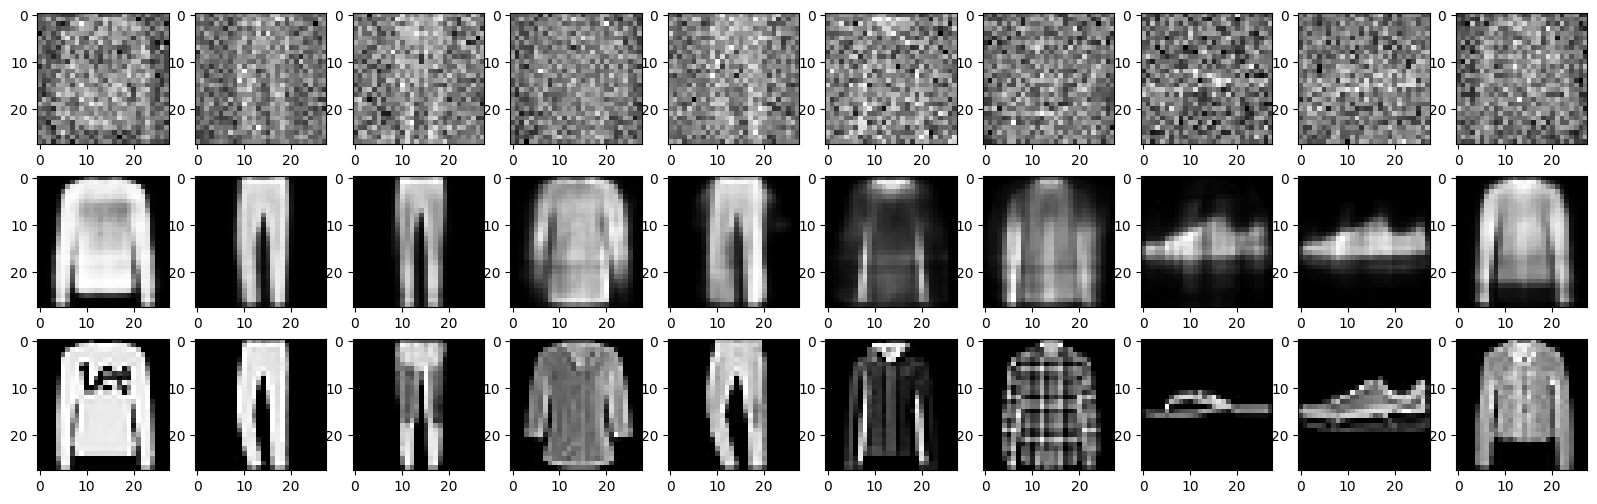

In [85]:
# Noise가 적용된 데이터 / Noise가 제거된 데이터, 그리고 Original 데이터를 비교
n = 10
plt.figure(figsize=(20, 6))

for i in range(1, n + 1):
 ax = plt.subplot(3, n, i) # 노이즈가 적용된 이미지를 표시한다.
 plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
 plt.gray()

 ax = plt.subplot(3, n, i + n) # 노이즈가 제거된 이미지를 표시한다.
 plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
 plt.gray()

 ax = plt.subplot(3, n, i + 2*n) # 원본 이미지를 표시한다.
 plt.imshow(original_test[i].reshape(28, 28), cmap='gray')
 plt.gray()
plt.show()

- Autoencoder 모델을 이용하여 Noise가 있는 Image를 denoising 기술을 적용하였다.
- Noise가 있는 첫 그림들은 형체를 알아볼 수 없을 정도였다.
- 노이즈가 제거된 이미지의 전체적 형태는 원본 이미지와 유사하다.
- 노이즈가 제거된 이미지는 세부적인 feature의 pattern이 자세히 보이지 않아 흐리고, 불규칙한 패턴이 많았다.

- Autoencoder와 Denoising Autoencoder를 사용했을 때, 이미지 압축/복원과 noise 제거가 성공적으로 이루어졌다 생각한다.

# 4. 후반부 교재인 “BERT와 GPT로 배우는 자연어 처리”에서 본인이 중요하다고 생각되는 5개의 키워드에 대해서 설명해보자.
- 설명할 분량은 본인이 임의로 정하면 된다. 단, 자연어 처리를 모르는 주변의 학생들에게 설명한다고 생각하면 되겠다.

## **1. Token & Tokenization(토큰과 토큰화)**

### Token(토큰)이란 무엇인가?
- 토큰은 본질적으로 의미 있는 Text이다. 이는 단어일 수도 있고, 단어의 일부일 수도 있고, 구두점일 수도 있다.
NLP에서는 "dog", "run", "!" 모두 토큰으로 취급한다. 토큰의 정의는 다양한 언어나 상황에서 사용되는 방식에 따라 달라질 수 있다.

### **Tokenization(토큰화)**란 무엇인가?
- 데이터의 기본 단위는 텍스트 형태의문장
- 트랜스포머 모델은 토큰 시퀀스를 입력받기에 문장에서 토큰화 수행이 필요
- 말뭉치에 포함된 text를 token이란 단위로 나누는 작업.
```
"This is a dog" -> 토큰화 -> "This", "is", "a", "dog"
```


---
**<추가정보>**
### 단어 단위 토큰화
- 단어(어절) 단위 토큰화 수행
    - 공백으로 분리
    - 별도 토크나이저 쓰지 않아도 됨
    - 어휘 집합(vocabulary)의 크기가 매우 커짐
- 은전한닢 토큰화
    - 어휘 집합의 크기가 커지는 것을 조금 완화 가능하나, 지나치게 커지는 것을 막기엔 부족함

## 토크나이저(Tokenizer)
- 토큰화를 수행하는 프로그램
- 대표적 한국어 토크나이저로 은전한닢(mecab), 꼬꼬마(kkma) 등 존재
- 토큰화뿐만 아닌 품사부착(part-of-tagging)까지 수행하기에 토큰화 개념을 넓은 의미로 해설할 땐, 토큰 나누기에 품사 부착까지 일컫기도 함

## 2. Transformer Architecture(트랜스포머)

- 2017년 "Attention is All You Need"라는 제목의 논문에서 소개된 모델로, 현재 자연어 처리 분야에서 기본이 되는 모델이다.
- 이는 번역/요약에서 자주 사용되며 예시로, GPT나 Bert 모델도 Transformer를 기반으로 작동한다.
- 인코더와 디코더로 구성되는데, 이를 언어 번역을 예시로 들면 "빠른 갈색 여우가 게으른 개를 뛰어넘는다" 라는 문장을 1번에서 말한 토큰화 과정을 거쳐 "빠르다" "갈색" "여우" "게으르다" "개" "뛰어넘다"가 되고, 스페인어로 번역하면 "El rápido" "zorro" "marrón salta" "sobre" "el perro" "perezoso"가 된다. 이 과정에서 인코더와 디코더가 작동하는데, 인코더는 시퀀스 정보를 압축하여 디코더로 전송한다. 디코더는 인코더에서 받은 시퀀스 정보를 타킷 시퀀스로 생성한다. 이러한 언어 번역 과정이 디코딩 과정이다.


## 3. Fine-Tuning(파인튜닝)

- 파인튜닝은 특정 작업 혹은 Domain에서 잘 작동하게 하기 위해서, 훈련된 모델의 가중치 등에 특정 데이터셋을 적용하여 추가적인 학습을 진행하는 방법이다.
- 예로, LLM에서 다양한 언어에 대해 학습되있고, 대화가 가능하다고 생각하자. 그런데, 사용자가 의사와 대화하듯이 EEG등 의료 분야에 대해 질문을 하게 되면, LLM은 의료데이터 분야에 대해 학습이 되어있어야 한다. 사용자가 "아스피린과 파타놀 점안액을 함께 사용해도 신체에 부담이 없나요?"라고 질문이 들어오면, 정확한 답을 제공하기 위해서 모델을 파인튜닝하여 해당 도메인 지식을 탑재하고 있어야 하는 것이다.
- 그런데, 앞선 예시와 같이 다양한 도메인 지식을 학습시키기 위해선 많은 데이터가 필요하기에, 시간과 돈 등 자원이 많이 필요하다. GPT 등을 제외하고 현재 중국의 텐센트 기업이 막대한 자본을 투자하여 도메인 지식을 대량으로 학습시키고 있다고 3주 전 기사가 뜨기도 하였다.

## 4. GPT(Generative Pre-training Transformer)
- 인터넷에서 수집한 방대한 양의 텍스트 테이터(책, 웹사이트, 기사 등)으로 학습된 OpenAI에 의해 개발된 대형 언어 모델이다.
- GPT의 핵심 알고리즘은 '토큰화'와 '확률'에 기반을 둔다. 입력된 텍스트를 최소 단위인 토큰으로 분해한 후, 이 토큰들의 순서와 조합을 바탕으로 다음에 올 텍스트를 예측한다. 이 과정에서 수많은 숫자를 계산하여 가장 적절한 답변을 언어로 출력한다.
- 이러한 방식은 단순히 정답을 찾아주었던 지난 날에 검색 엔진이나 챗봇과 달리 주어진 정보를 기반으로 다양한 가능성 중 최적의 답변을 제시하며 창의적인 요구에 대응할 수 있다.
---
### 추가정보
- GPT를 잘 활용하기 위해선, 좋은 질문을 하는 방법을 배우고 AI가 제공하는 답변을 해석하는 능력을 키워야한다. 단순히 작업을 더 빠르게 처리하는 것을 넘어서 정보를 이해하고 활용하는 방식을 변화시켜 함께 성장할 수 있는 기회로 삼아야한다.

## 5. NLP(Natural Language Processing, 자연어처리)

- 자연어 처리(NLP)는 컴퓨터에게 인간과 매우 유사한 방식으로 텍스트 및 음성 언어를 이해하는 능력을 부여하는 것과 관련된 컴퓨터 공학의 한 분야, 더 구체적으로 말하자면  인공지능(AI)의 한 분야이다.
- 인간 언어를 규칙 기반으로 모델링하는 전산언어학과 통계적 머신 러닝 및 딥 러닝 모델을 결합한 것이다. 이러한 기술은 컴퓨터가 텍스트 or 음성 데이터의 형태로 인간의 언어를 처리하고, 발화자 또는 작성자의 의도와 감정을 포함한 완전한 의미를 '이해'할 수 있도록 한다.
- NLP는 신속하게 그리고 심지어 실시간으로 텍스트를 한 언어에서 다른 언어로 번역하고, 음성 명령에 응답하며, 대량의 텍스트를 요약하는 컴퓨터 프로그램을 지원한다.
- 예로, 음성 작동 GPS 시스템, 디지털 상담원, 음성-텍스트 받아쓰기 소프트웨어, 고객 서비스 챗봇 및 기타 소비자를 위한 편의 시스템의 형태로 NLP와 상호작용한 경험이 있을 것이다. 그러나 NLP는 비즈니스 운영을 효율화하고, 생산성을 높이고, 미션 크리티컬 비즈니스 프로세스를 간소화하도록 돕는 엔터프라이즈 솔루션에서도 점점 더 큰 역할을 수행하고 있습니다.
-  NLP 기반 툴의 또다른 예로는 웹 검색, 스팸 메일 필터링, 텍스트 또는 음성 자동 번역, 문서 요약, 감정 분석, 문법/철자 검사 등이 있다. 예를 들어 일부 이메일 프로그램은 메시지 내용을 바탕으로 해당 메시지에 대한 적절한 회신 내용을 자동으로 제안할 수 있는데, 바로 NLP를 사용하여 메시지를 읽고, 분석하고, 응답하는 것이다.

[ref7] [링크](https://www.ibm.com/kr-ko/topics/natural-language-processing)

# 과제 소감문
OCL LAB(지도교수: 이영호)에서 학부연구생으로 활동하며, 옆자리 친구가 Bert모델을 가지고 연구를 진행하는 것이 NLP에 대하여 관심을 가지게 된 이유였습니다. 졸업학점인 120학점을 다 채워 수강하지 않아도 되었으나, 지난학기 이상홍 교수님의 기계학습 프로그래밍 수업이 재미있었기에 교수님을 한 번 더 뵙고싶어 수강하게 되었습니다.
해당수업을 수강하며 부족하였던 딥러닝 지식들을 채워갈 수 있었으며, 과제 또한 항상 재미있게 하고 있습니다. 현재 EEG 데이터를 이용한 연구를 진행중에 있는데, 이를 LLM에도 활용하면 좋을 것 같다 생각하게 되었습니다.